In [1]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.utils import resample

#sklearn package 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn. preprocessing import LabelEncoder,StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB,MultinomialNB,GaussianNB 

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier

#model evaluation
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,recall_score,precision_score,f1_score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thanh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#read the dataset
data = pd.read_json('./News_Category_Dataset_v3.json',lines=True) # lines for avoid the trailing error
column = data.columns
column

Index(['link', 'headline', 'category', 'short_description', 'authors', 'date'], dtype='object')

In [3]:
data.drop(['link','date'],axis=1,inplace = True)
data.head(4)

,headline,category,short_description,authors
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP"
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna


In [4]:
data.describe()

,headline,category,short_description,authors
count,209527,209527,209527,209527
unique,207996,42,187022,29169
top,Sunday Roundup,POLITICS,,
freq,90,35602,19712,37418


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   headline           209527 non-null  object
 1   category           209527 non-null  object
 2   short_description  209527 non-null  object
 3   authors            209527 non-null  object
dtypes: object(4)
memory usage: 6.4+ MB


In [6]:
print("The shape of the dataset-------->",data.shape)
print("The number of null values ------>")
print(data.isnull().sum())
column = data.columns
print("The column present there-------->",column)

The shape of the dataset--------> (209527, 4)
The number of null values ------>
headline             0
category             0
short_description    0
authors              0
dtype: int64
The column present there--------> Index(['headline', 'category', 'short_description', 'authors'], dtype='object')


# Category walkthrough

In [7]:
print("The total number category present here------------->",data['category'].nunique())
category=data['category'].value_counts()
print(category)

The total number category present here-------------> 42
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144

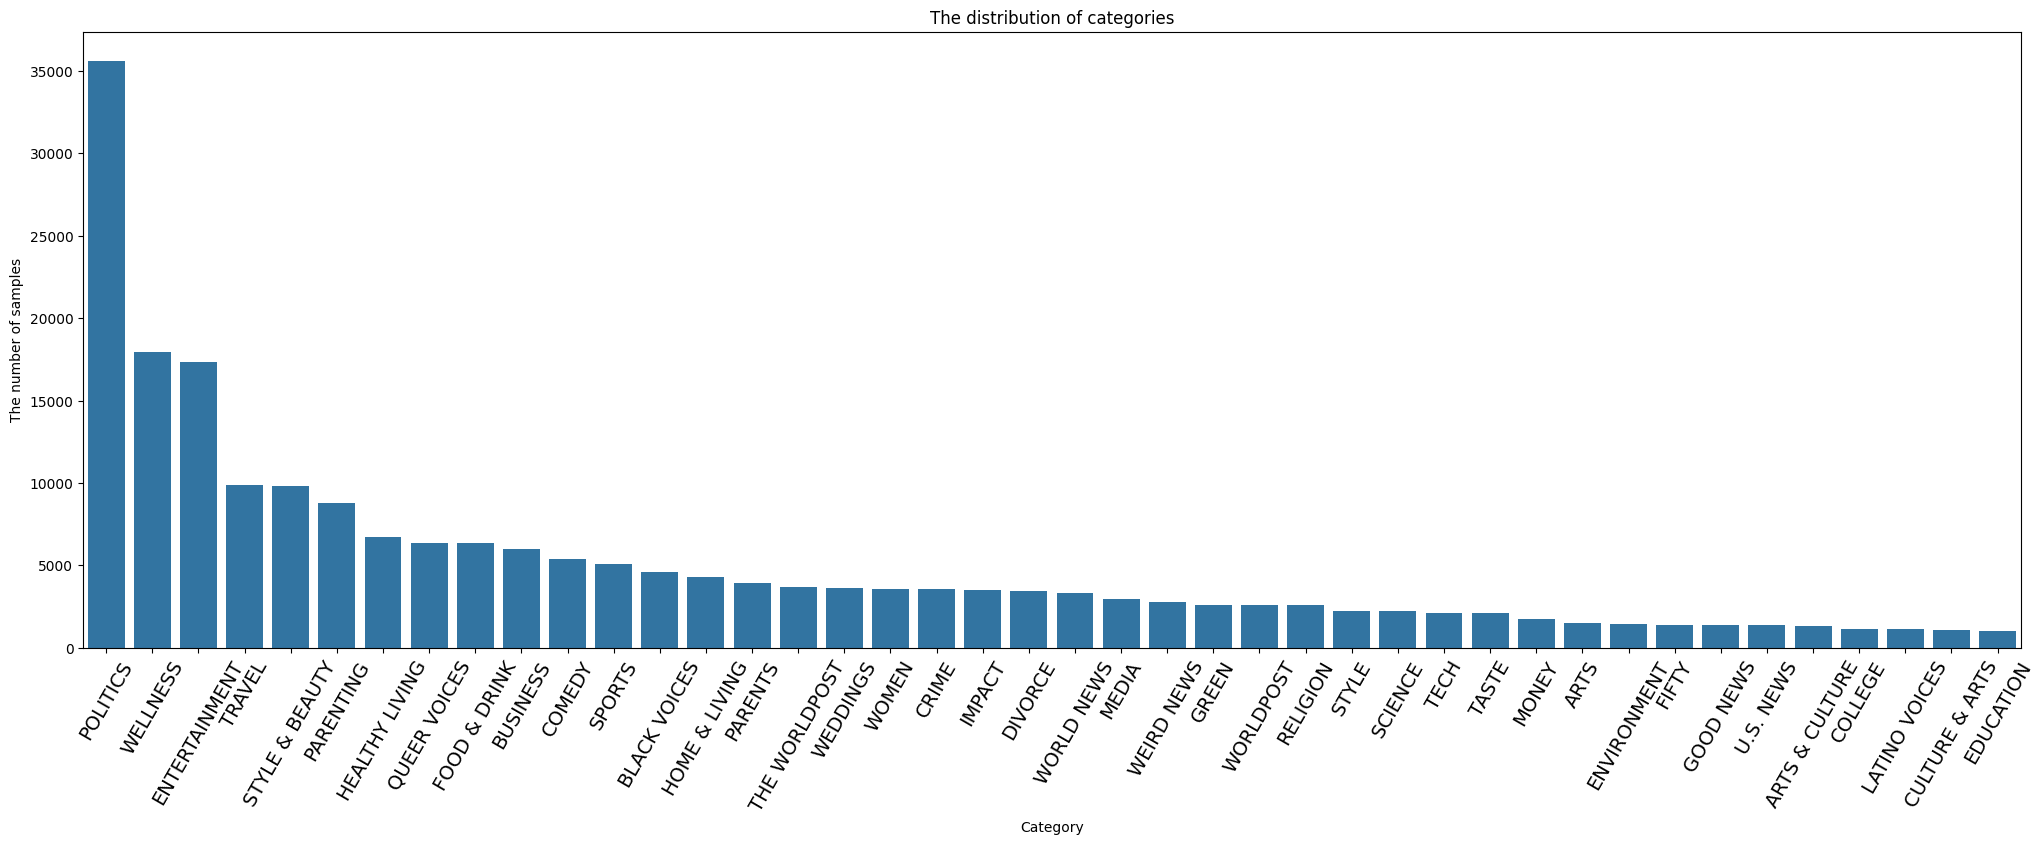

In [8]:
plt.figure(figsize=(25,8))
sns.barplot(x=category.index,y=category.values)
plt.title("The distribution of categories")
plt.xlabel("Category")
plt.ylabel("The number of samples")

plt.xticks(rotation=60,fontsize = 14)
plt.show()

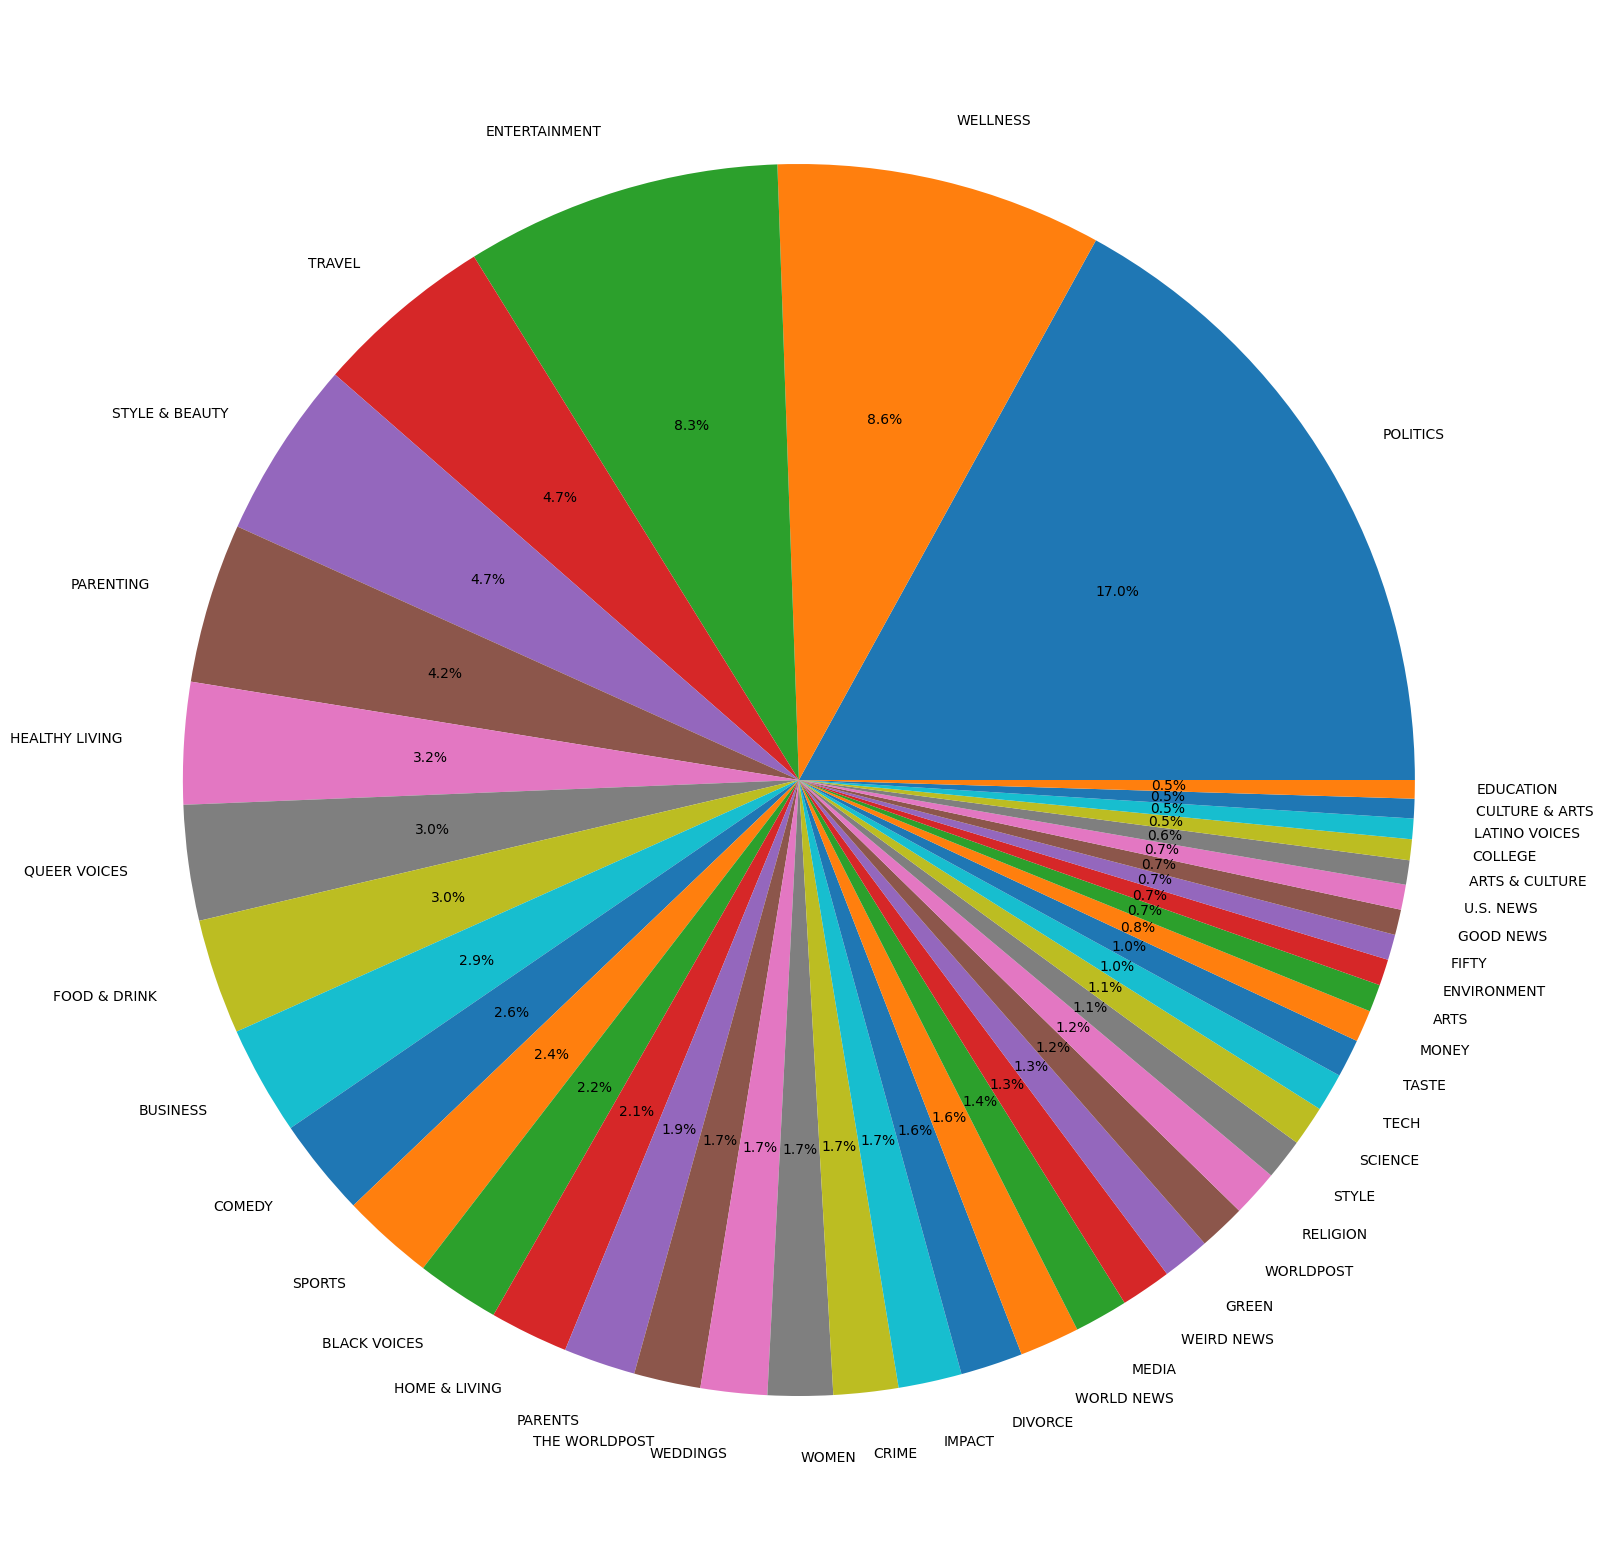

<Figure size 640x480 with 0 Axes>

In [9]:
#pie chart 
plt.figure(figsize=(20,20))
plt.pie(category.values, autopct="%1.1f%%", labels=category.index)
plt.show()
plt.savefig(r"./category_pie.png")

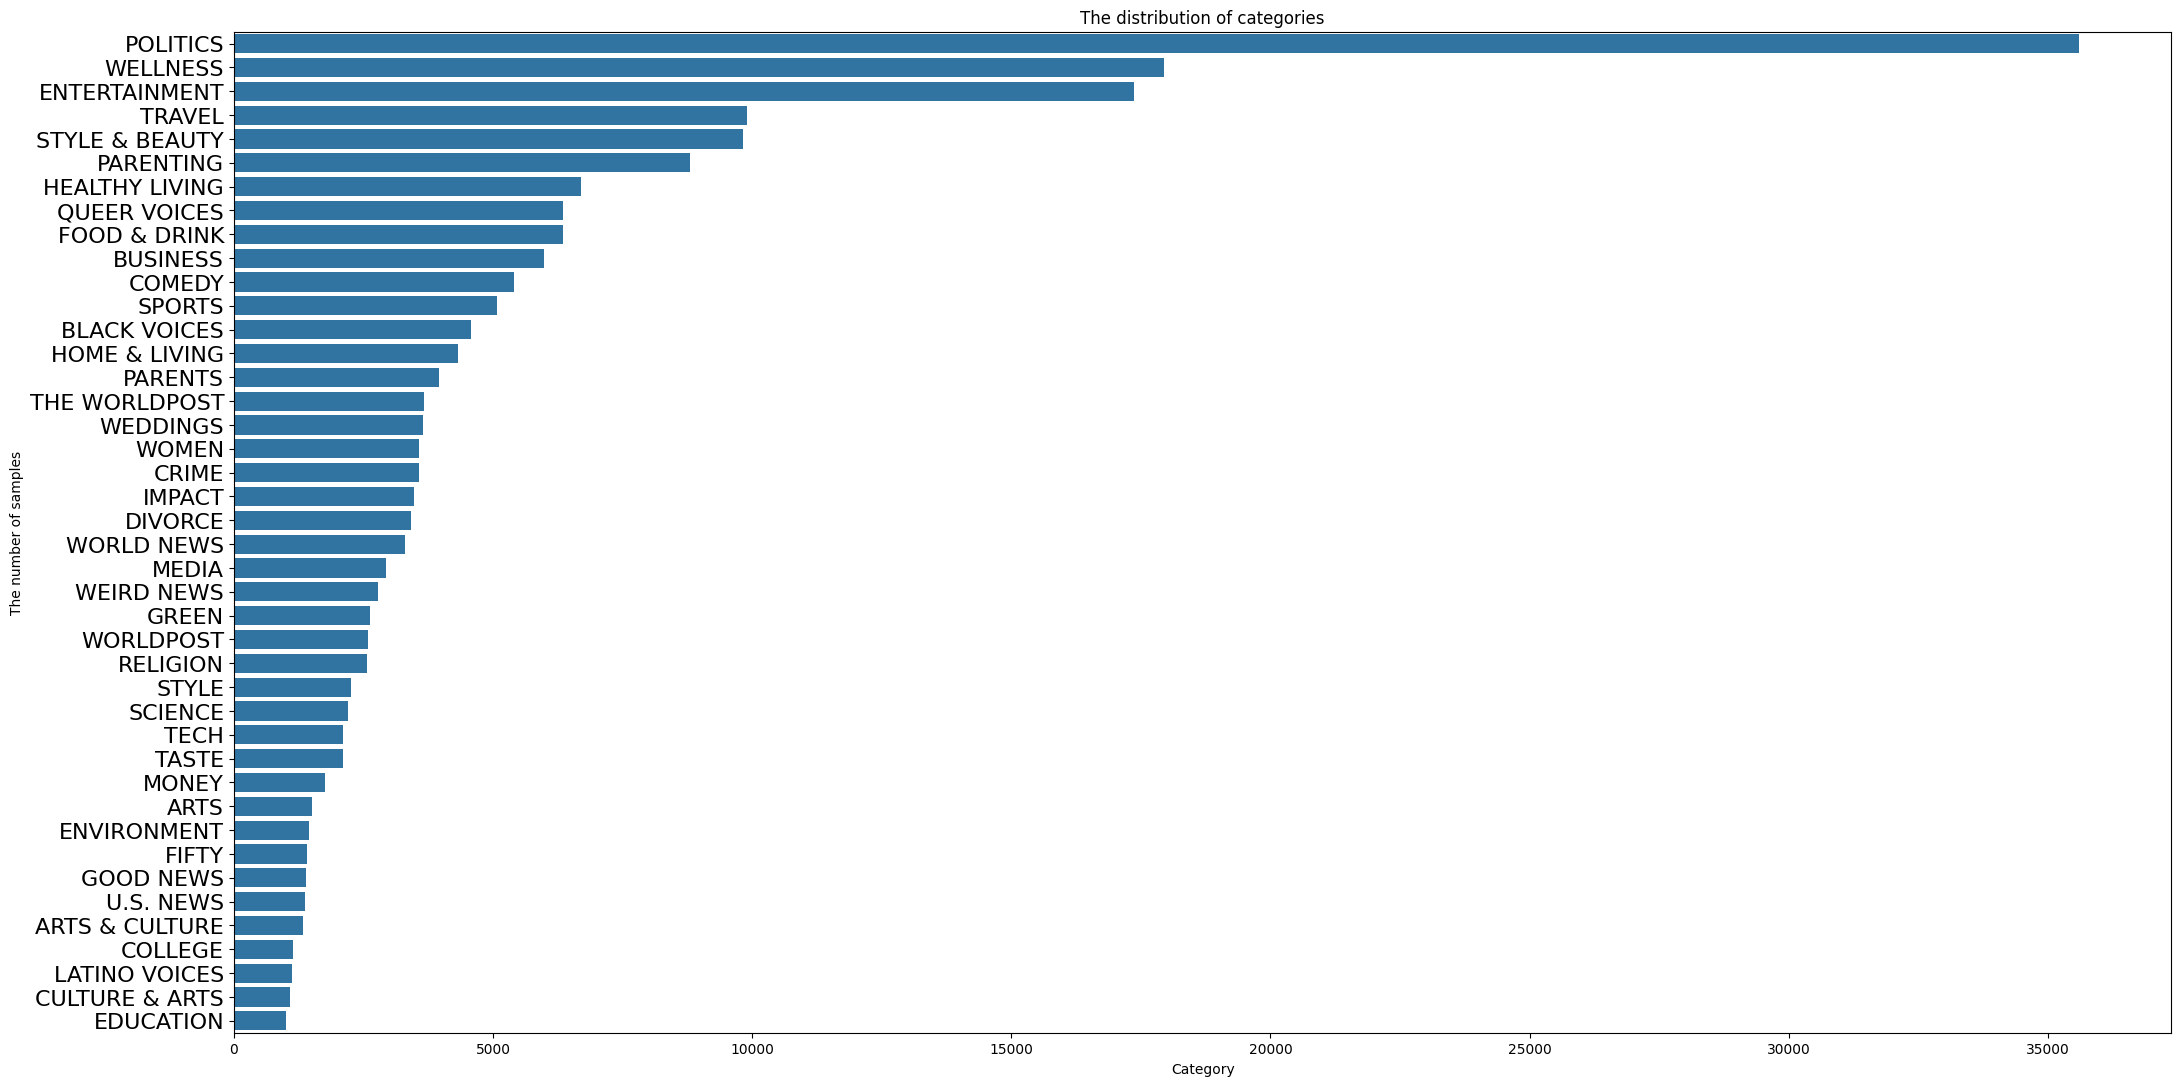

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=(25,13))
sns.barplot(y=category.index,x=category.values)
plt.title("The distribution of categories")
plt.xlabel("Category")
plt.ylabel("The number of samples")

plt.yticks(rotation=0,fontsize = 16)
plt.show()
plt.savefig(r"./category_bar.png")

There are unqual number of sample in each category, so we can drop some category and make it balanced

# handling Dublicate and null values

In [11]:
#delete the dublicate values
data.duplicated().sum() # count the total duplicate samples

447

In [12]:
data.drop_duplicates(keep='last',inplace=True)

In [13]:
#there can be dublicate of author names so check for the dublicate headline and short discription
data.duplicated(subset=['headline', 'short_description']).sum()

42

In [14]:
data.drop_duplicates(subset=['headline', 'short_description'],inplace=True,keep='last')

In [15]:
print("THe length of the datset after dublicate deletion------>",data.shape)

THe length of the datset after dublicate deletion------> (209038, 4)


# Handling null values

In [16]:
data.isnull().sum()

headline             0
category             0
short_description    0
authors              0
dtype: int64

In [17]:
# there is no null value instead of null they are blank so we need to check for the blank placess and delete that
data[data['headline'] == '']

,headline,category,short_description,authors
95567,,RELIGION,Let everyone not wrapped in tired and disprove...,"Matthew Fox, ContributorRadical theologian Mat..."
122145,,QUEER VOICES,,"Gary Snyder, ContributorWriter and Media Strat..."


In [18]:
# drop the blank values
headline_blank = data['headline'] == ''
data = data[~headline_blank]
print("THe length of the datset ------>",data.shape)

THe length of the datset ------> (209036, 4)


In [19]:
#drop the blank short describtion column
description_blank = data['short_description']==''
print("the lenth of the blank description samples----->",len(data[description_blank]))
data = data[~description_blank]
print("THe length of the datset ---------------------->",data.shape)

the lenth of the blank description samples-----> 19610
THe length of the datset ----------------------> (189426, 4)


In [20]:
#drop the null author samples
author_blank = data['authors']==''
print("the lenth of the blank auhtor samples---------->",len(data[author_blank]))
data = data[~author_blank]
print("THe length of the datset ---------------------->",data.shape)

the lenth of the blank auhtor samples----------> 32853
THe length of the datset ----------------------> (156573, 4)


In [21]:
data.head(5)

,headline,category,short_description,authors
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP"
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski


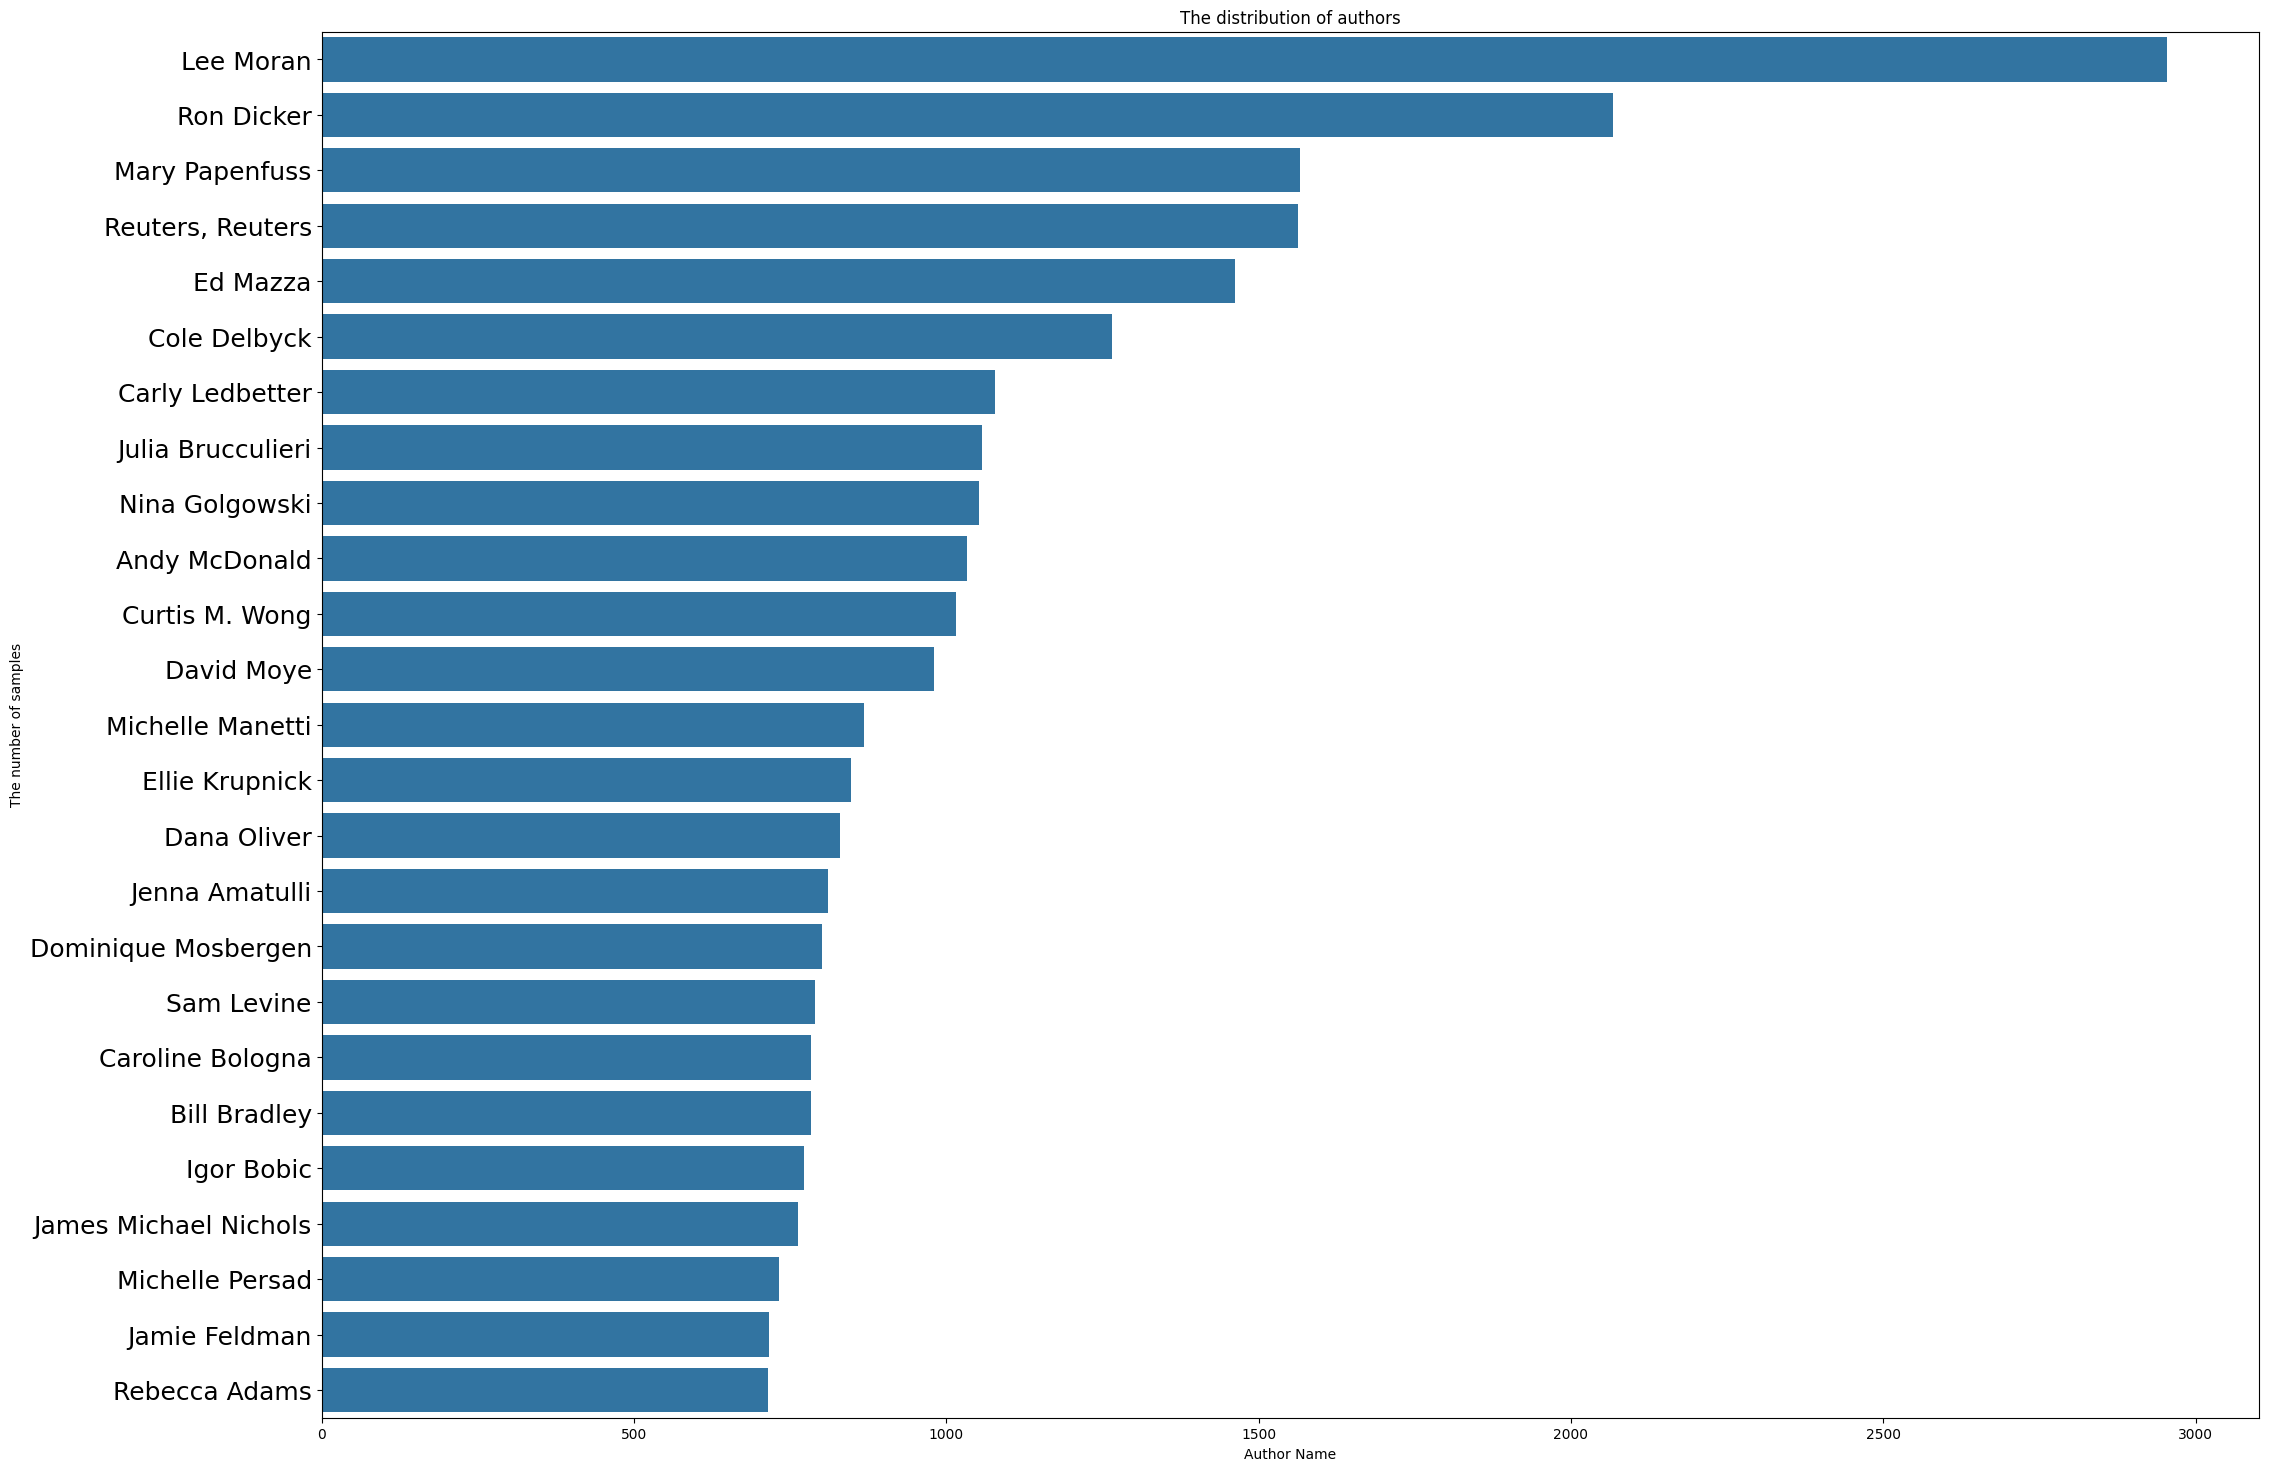

<Figure size 640x480 with 0 Axes>

In [22]:
#author 
#auhtor plot
auhtor_count = data['authors'].value_counts()

plt.figure(figsize=(25,18))
sns.barplot(y=auhtor_count[:25].index,x=auhtor_count[:25].values)
plt.title("The distribution of authors")
plt.xlabel("Author Name")
plt.ylabel("The number of samples")

plt.yticks(rotation=0,fontsize = 18)
plt.show()
plt.savefig(r"./author_bar.png")

# Balance the category data

In [23]:
category = data['category'].value_counts()
list(category.index)

['POLITICS',
 'ENTERTAINMENT',
 'WELLNESS',
 'TRAVEL',
 'STYLE & BEAUTY',
 'PARENTING',
 'HEALTHY LIVING',
 'QUEER VOICES',
 'FOOD & DRINK',
 'BUSINESS',
 'COMEDY',
 'SPORTS',
 'HOME & LIVING',
 'PARENTS',
 'BLACK VOICES',
 'IMPACT',
 'WOMEN',
 'WORLD NEWS',
 'THE WORLDPOST',
 'MEDIA',
 'CRIME',
 'WEIRD NEWS',
 'TASTE',
 'RELIGION',
 'WEDDINGS',
 'DIVORCE',
 'GREEN',
 'TECH',
 'MONEY',
 'STYLE',
 'SCIENCE',
 'ARTS & CULTURE',
 'WORLDPOST',
 'U.S. NEWS',
 'FIFTY',
 'GOOD NEWS',
 'EDUCATION',
 'LATINO VOICES',
 'ARTS',
 'COLLEGE',
 'ENVIRONMENT',
 'CULTURE & ARTS']


we can drop the Style, Education, College and Environment they are having very less number of sample, which may lead to less accuracy and f1 score.

In [24]:
cateo_keep = (data['category'] == 'POLITICS') | (data['category'] == 'WELLNESS' )| (data['category'] == 'ENTERTAINMENT') | (data['category'] == 'TRAVEL') | \
            (data['category'] == 'STYLE & BEAUTY') | (data['category'] == 'PARENTING' )| (data['category'] == 'HEALTHY LIVING') | (data['category'] == 'QUEER VOICES') | \
              (data['category'] == 'FOOD & DRINK') | (data['category'] == 'BUSINESS' )| (data['category'] == 'COMEDY') | (data['category'] == 'PARENTS') | (data['category'] == 'SPORTS') | (data['category'] == 'HOME & LIVING' )| (data['category'] == 'BLACK VOICES')
data = data[cateo_keep]



In [25]:
category = data['category'].value_counts()
category

category
POLITICS          29673
ENTERTAINMENT     13461
WELLNESS          12944
TRAVEL             8021
STYLE & BEAUTY     7173
PARENTING          6517
HEALTHY LIVING     5071
QUEER VOICES       4699
FOOD & DRINK       4527
BUSINESS           4372
COMEDY             3934
SPORTS             3608
HOME & LIVING      3490
PARENTS            3451
BLACK VOICES       3310
Name: count, dtype: int64

In [26]:
data_1 = data[data['category'] == 'POLITICS']
data_1 = resample(data_1, replace=False, n_samples=3000, random_state=123)
data_2 = data[data['category'] == 'WELLNESS']
data_2 = resample(data_2, replace=False, n_samples=3000, random_state=123)
data_3 = data[data['category'] == 'ENTERTAINMENT']
data_3 = resample(data_3, replace=False, n_samples=3000, random_state=123)
data_4 = data[data['category'] == 'TRAVEL']
data_4 = resample(data_4, replace=False, n_samples=3000, random_state=123)
data_5 = data[data['category'] == 'STYLE & BEAUTY']
data_5 = resample(data_5, replace=False, n_samples=3000, random_state=123)
data_6 = data[data['category'] == 'PARENTING']
data_6 = resample(data_6, replace=False, n_samples=3000, random_state=123)
data_7 = data[data['category'] == 'HEALTHY LIVING']
data_7 = resample(data_7, replace=False, n_samples=3000, random_state=123)
data_8 = data[data['category'] == 'QUEER VOICES']
data_8 = resample(data_8, replace=False, n_samples=3000, random_state=123)
data_9 = data[data['category'] == 'FOOD & DRINK']
data_9 = resample(data_9, replace=False, n_samples=3000, random_state=123)
data_10 = data[data['category'] == 'BUSINESS']
data_10 = resample(data_10, replace=False, n_samples=3000, random_state=123)
data_11 = data[data['category'] == 'COMEDY']
data_11 = resample(data_11, replace=False, n_samples=3000, random_state=123)
data_12= data[data['category'] == 'PARENTS']
data_12 = resample(data_12, replace=False, n_samples=3000, random_state=123)
data_13= data[data['category'] == 'SPORTS']
data_13 = resample(data_13, replace=False, n_samples=3000, random_state=123)
data_14 = data[data['category'] == 'HOME & LIVING']
data_14 = resample(data_14, replace=False, n_samples=3000, random_state=123)
data_15 = data[data['category'] == 'BLACK VOICES']
data_15 = resample(data_15, replace=False, n_samples=3000, random_state=123)

cato_list = [data_1 , data_2 , data_3 , data_4 ,data_5 , data_6 , data_7, data_8 , data_9 , data_10, data_11 , data_12 , data_13, data_14 ,data_15]

data = pd.concat(cato_list)
data['category'].value_counts()

category
POLITICS          3000
WELLNESS          3000
ENTERTAINMENT     3000
TRAVEL            3000
STYLE & BEAUTY    3000
PARENTING         3000
HEALTHY LIVING    3000
QUEER VOICES      3000
FOOD & DRINK      3000
BUSINESS          3000
COMEDY            3000
PARENTS           3000
SPORTS            3000
HOME & LIVING     3000
BLACK VOICES      3000
Name: count, dtype: int64

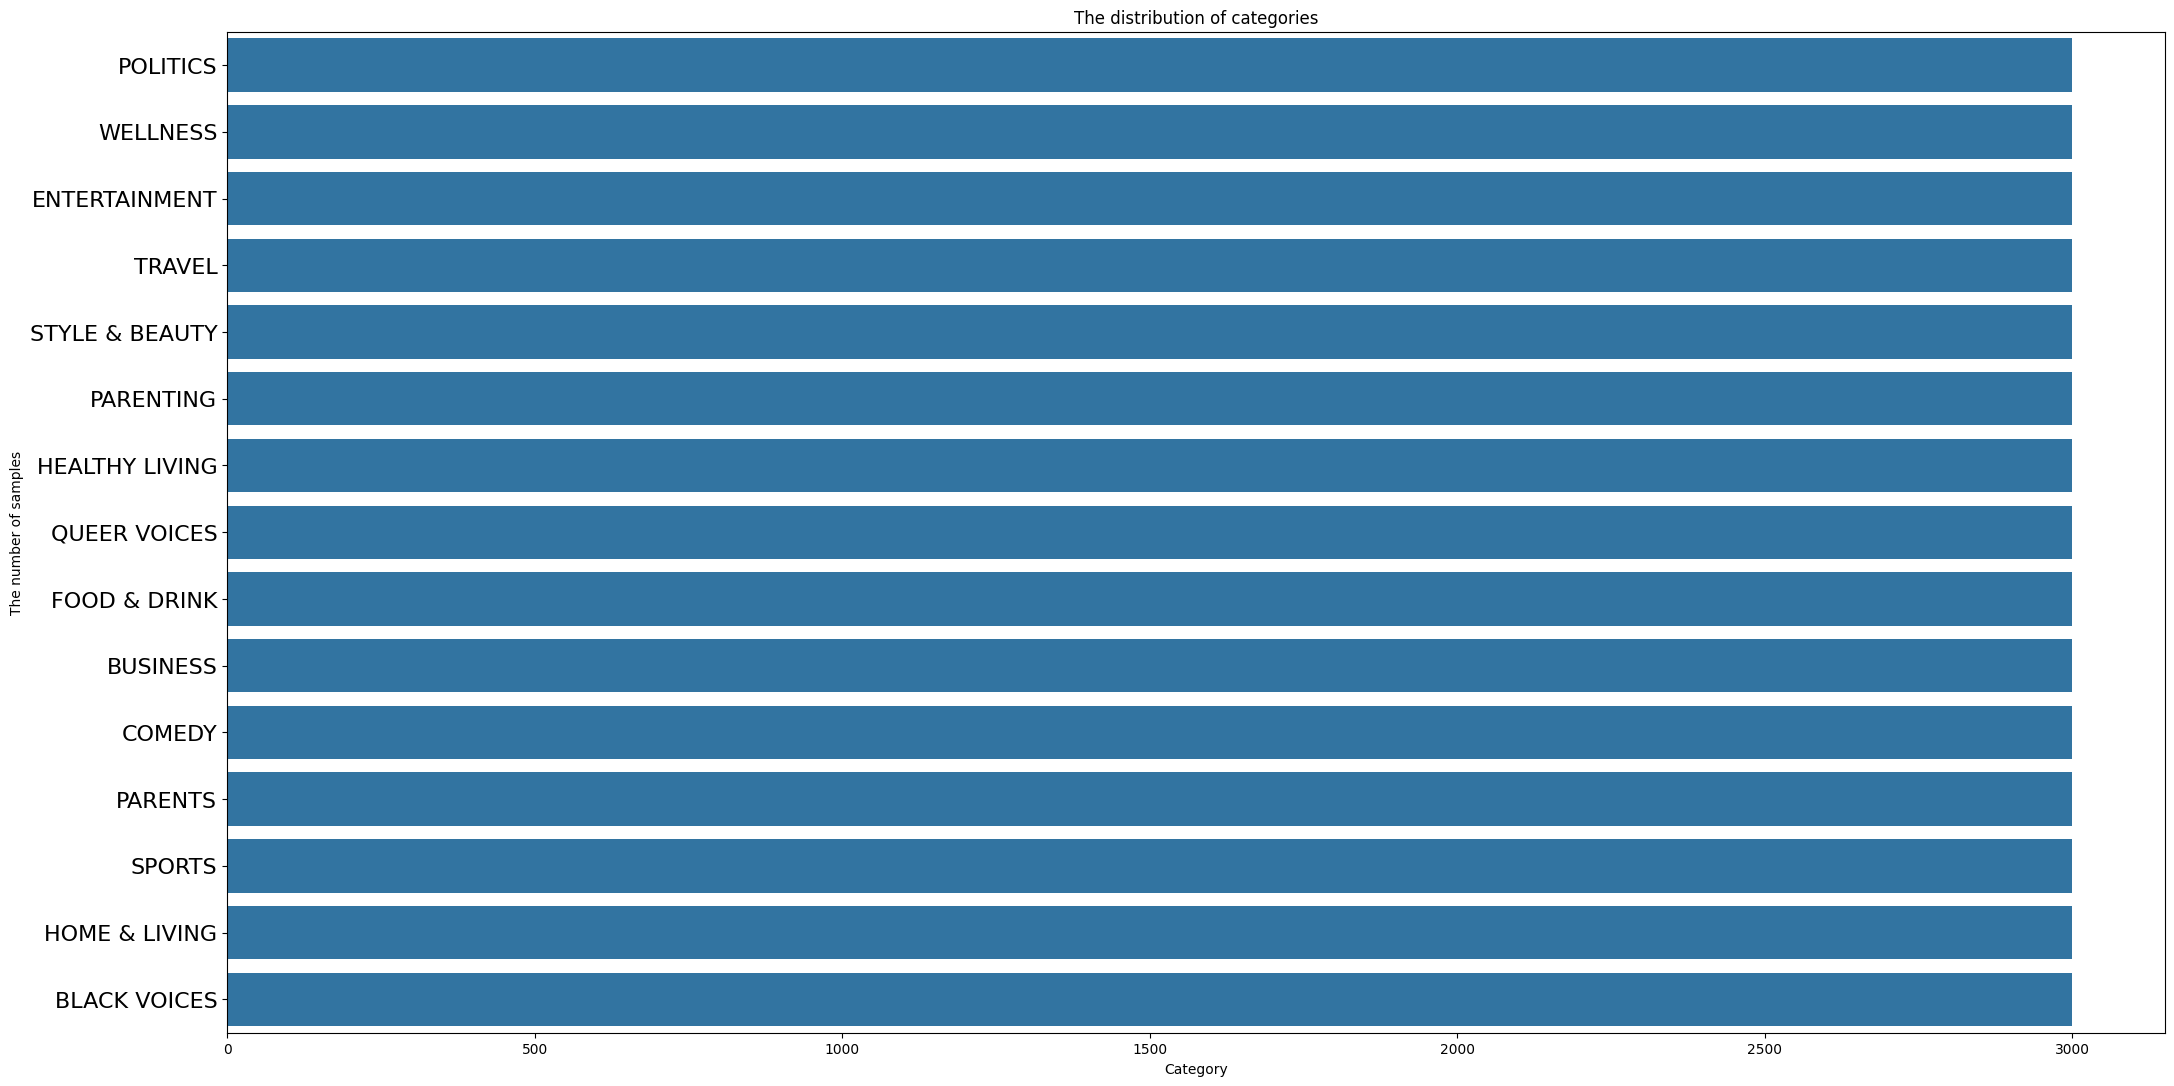

<Figure size 640x480 with 0 Axes>

In [27]:
category = data['category'].value_counts()
plt.figure(figsize=(25,13))
sns.barplot(y=category.index,x=category.values)
plt.title("The distribution of categories")
plt.xlabel("Category")
plt.ylabel("The number of samples")

plt.yticks(rotation=0,fontsize = 16)
plt.show()
plt.savefig(r"./category_bar.png")

# Column Combinning

In [28]:
data['text'] = data['headline']+'-'+data['short_description']

In [29]:
data.head(4)

,headline,category,short_description,authors,text
75921,Donald Trump Booed After Telling Jeb Bush To P...,POLITICS,A high-energy clash between the two Republican...,Igor Bobic,Donald Trump Booed After Telling Jeb Bush To P...
14036,U.S. Officials Tell World Leaders To Ignore Tr...,POLITICS,Americans tried to calm rattled leaders at an ...,Mary Papenfuss,U.S. Officials Tell World Leaders To Ignore Tr...
55583,Trump Claims Stop And Frisk Suppressed Crime I...,POLITICS,The policy has also been ruled unconstitutional.,Ryan J. Reilly,Trump Claims Stop And Frisk Suppressed Crime I...
8030,Melania Trump’s Colonialist Outfit During Afri...,POLITICS,"""I'll need a colonizer outfit,"" one Twitter us...",Mary Papenfuss,Melania Trump’s Colonialist Outfit During Afri...


In [30]:
#drop the other columns
data.drop(['authors','headline','short_description'],axis=1,inplace=True)

In [31]:
print("The lenth of the datset-------------------->",data.shape)
data.head(4)

The lenth of the datset--------------------> (45000, 2)


,category,text
75921,POLITICS,Donald Trump Booed After Telling Jeb Bush To P...
14036,POLITICS,U.S. Officials Tell World Leaders To Ignore Tr...
55583,POLITICS,Trump Claims Stop And Frisk Suppressed Crime I...
8030,POLITICS,Melania Trump’s Colonialist Outfit During Afri...


In [32]:
from sklearn.utils import shuffle
data = shuffle(data)
data.reset_index(inplace=True, drop=True) 
data.head(4)

,category,text
0,PARENTING,Joaquin Phoenix: Don't Bite the Hand That Feed...
1,PARENTING,Parenting Advice: When Your Gay Child Comes Ou...
2,QUEER VOICES,Here Is An Amazing And Easy Way To Explain Fem...
3,WELLNESS,Coronavirus Death: British Man Is Sixth To Die...


# test cleaning

In [33]:
"""corpus=[]
for i in range(100000):
    text = data.iloc[i,1]
    
    text = text.lower()
    text = re.sub('[^a-z0-9]',' ',text)
    text = text.split()
    
    s = PorterStemmer()
    text = [s.stem(word) for word in text if not word in set(stopwords.words('english')) ]
    text = ' '.join(text)
    corpus.append(text)
    
    if i%1000==0:
        print(i,end='->')"""


"corpus=[]\nfor i in range(100000):\n    text = data.iloc[i,1]\n    \n    text = text.lower()\n    text = re.sub('[^a-z0-9]',' ',text)\n    text = text.split()\n    \n    s = PorterStemmer()\n    text = [s.stem(word) for word in text if not word in set(stopwords.words('english')) ]\n    text = ' '.join(text)\n    corpus.append(text)\n    \n    if i%1000==0:\n        print(i,end='->')"

In [34]:
"""corpus = pd.read_csv('../input/corpus/corpus.csv')
corpus"""

"corpus = pd.read_csv('../input/corpus/corpus.csv')\ncorpus"


# Tokazitation and Count Vectorization

In [35]:
#train and test split
X = data['text']
#label encoding the target
label = LabelEncoder()
y = label.fit_transform(data['category'])

#split the train and test dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state=2)

In [36]:
print("The X_train shape----->",X_train.shape)
print('The X_text shape------>',X_test.shape)
print("THe y_train shape----->",y_train.shape)
print("The y_test shape------>",y_test.shape)

The X_train shape-----> (40500,)
The X_text shape------> (4500,)
THe y_train shape-----> (40500,)
The y_test shape------> (4500,)


In [37]:
#ifidf vectorizer

vecto =  TfidfVectorizer(stop_words='english',max_df = 0.99,min_df=10,
                                   ngram_range=(1, 2),lowercase=True, max_features=5000)
vecto = vecto.fit(X_train)

X_train = vecto.transform(X_train).toarray()
X_test = vecto.transform(X_test).toarray()
X_train.shape

(40500, 5000)

In [38]:
print(vecto.get_feature_names_out())

['000' '10' '10 000' ... 'zimmerman' 'zoe' 'zone']


In [39]:
tfidf_df = pd.DataFrame(X_train,columns = vecto.get_feature_names_out())
tfidf_df.head(4)

,000,10,10 000,10 best,10 reasons,10 things,10 ways,10 years,100,100 percent,...,youth,youtube,zealand,zen,zero,zika,zika virus,zimmerman,zoe,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
print("The X_train shape----->",X_train.shape)
print('The X_text shape------>',X_test.shape)
print("THe y_train shape----->",y_train.shape)
print("The y_test shape------>",y_test.shape)

The X_train shape-----> (40500, 5000)
The X_text shape------> (4500, 5000)
THe y_train shape-----> (40500,)
The y_test shape------> (4500,)


# Model training

In [41]:

def classifier_scores(y_train,y_test, pred_train, pred_test):
    
    print()
    print("Train data accuracy score: ", accuracy_score(y_train,pred_train))    
    print("Test data accuracy score: ", accuracy_score(y_test,pred_test))
    print()
    print("Recall score on train data: ", recall_score(y_train,pred_train, average='macro'))
    print("Recall score on test data: ",recall_score( y_test,pred_test, average='macro'))
    print()
    
    print("Precision score on train data: ",precision_score(y_train,pred_train, average='macro'))
    print("Precision score on test data: ",precision_score(y_test,pred_test, average='macro'))
    print()
    print("F1 score on train data: ",f1_score(y_train,pred_train, average='macro'))
    print("F1 score on test data: ",f1_score(y_test,pred_test, average='macro'))

## Multinomial Naive Bayes

In [42]:
print("Multinamial NB----------------------------------->")
multinb = MultinomialNB()
multinb.fit(X_train , y_train)

y_train_pred = multinb.predict(X_train)
y_test_pred = multinb.predict(X_test)
classifier_scores(y_train,y_test,y_train_pred,y_test_pred)

Multinamial NB----------------------------------->

Train data accuracy score:  0.7275802469135803
Test data accuracy score:  0.6231111111111111

Recall score on train data:  0.7276988409876342
Recall score on test data:  0.6225631789772161

Precision score on train data:  0.7313148841066861
Precision score on test data:  0.6281277539357599

F1 score on train data:  0.7275746937783022
F1 score on test data:  0.6224156314324568


## Complement Naive Bayes

In [43]:
print("Compiment NB----------------------------------->")
compnb = ComplementNB(alpha=1.0)
compnb.fit(X_train , y_train)

y_train_pred = compnb.predict(X_train)
y_test_pred = compnb.predict(X_test)
classifier_scores(y_train,y_test,y_train_pred,y_test_pred)

Compiment NB----------------------------------->

Train data accuracy score:  0.6841481481481482
Test data accuracy score:  0.6142222222222222

Recall score on train data:  0.6841927258933704
Recall score on test data:  0.6143581615823537

Precision score on train data:  0.6820006790233835
Precision score on test data:  0.6088646036080483

F1 score on train data:  0.6787455681596645
F1 score on test data:  0.6058822195818666


## Gaussian Naive Bayes

In [44]:
#model training
gaussion_NB = GaussianNB()
gaussion_NB.fit(X_train , y_train)

y_train_pred = gaussion_NB.predict(X_train)
y_test_pred = gaussion_NB.predict(X_test)
classifier_scores(y_train,y_test,y_train_pred,y_test_pred)


Train data accuracy score:  0.6137037037037038
Test data accuracy score:  0.412

Recall score on train data:  0.6139055436292126
Recall score on test data:  0.41039451889075135

Precision score on train data:  0.6924566438780678
Precision score on test data:  0.4446602595561791

F1 score on train data:  0.6006764532722074
F1 score on test data:  0.3965185206026346


## logistic Regresssion

In [45]:
#logistic Regresssion

log_reg = LogisticRegression()

log_reg.fit(X_train , y_train)

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
classifier_scores(y_train,y_test,y_train_pred,y_test_pred)

C:\Users\Thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Train data accuracy score:  0.7705925925925926
Test data accuracy score:  0.6322222222222222

Recall score on train data:  0.7706256740316347
Recall score on test data:  0.6330901203357405

Precision score on train data:  0.7718808264606797
Precision score on test data:  0.6373014291455956

F1 score on train data:  0.7703860392679232
F1 score on test data:  0.6335318804188991


In [46]:
#logistric regression more accuracy
log_reg_hyper = LogisticRegression(solver='liblinear',n_jobs=-1,penalty='l2',)
log_reg_hyper.fit(X_train , y_train)

y_train_pred = log_reg_hyper.predict(X_train)
y_test_pred = log_reg_hyper.predict(X_test)
classifier_scores(y_train,y_test,y_train_pred,y_test_pred)

C:\Users\Thanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(



Train data accuracy score:  0.7584197530864197
Test data accuracy score:  0.6333333333333333

Recall score on train data:  0.7584386357899896
Recall score on test data:  0.6340532999276455

Precision score on train data:  0.7591326634961825
Precision score on test data:  0.6358887958559415

F1 score on train data:  0.7576204956809456
F1 score on test data:  0.6327943043660516


### Model training with SVD

In [47]:
n_com = [500,1000,2000,3000]
def models_prepare():
    model = {}
    for n in n_com:
        s = [('svd',TruncatedSVD(n_components = n)),('logistric',LogisticRegression())]
        model[str(n)] = Pipeline(steps = s)
    return model
models = models_prepare()
models

{'500': Pipeline(steps=[('svd', TruncatedSVD(n_components=500)),
                 ('logistric', LogisticRegression())]),
 '1000': Pipeline(steps=[('svd', TruncatedSVD(n_components=1000)),
                 ('logistric', LogisticRegression())]),
 '2000': Pipeline(steps=[('svd', TruncatedSVD(n_components=2000)),
                 ('logistric', LogisticRegression())]),
 '3000': Pipeline(steps=[('svd', TruncatedSVD(n_components=3000)),
                 ('logistric', LogisticRegression())])}

In [48]:

for name,model in models.items():
    model.fit(X_train,y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print("The Logistric Regression Trained with svd n_components {} ".format(name))
    
    classifier_scores(y_train,y_test,y_pred_train,y_pred_test)

The Logistric Regression Trained with svd n_components 500 

Train data accuracy score:  0.6366913580246913
Test data accuracy score:  0.5844444444444444

Recall score on train data:  0.6366925517969302
Recall score on test data:  0.5851354035569855

Precision score on train data:  0.6398011789757683
Precision score on test data:  0.590593740928678

F1 score on train data:  0.6368334361929807
F1 score on test data:  0.5860421747855139
The Logistric Regression Trained with svd n_components 1000 

Train data accuracy score:  0.6782716049382717
Test data accuracy score:  0.6035555555555555

Recall score on train data:  0.6782866539382357
Recall score on test data:  0.6045488824217778

Precision score on train data:  0.6808288922967829
Precision score on test data:  0.6086668673496592

F1 score on train data:  0.6782928863868665
F1 score on test data:  0.6045352133671998
The Logistric Regression Trained with svd n_components 2000 

Train data accuracy score:  0.7212592592592593
Test data a

# save the best model for later use

In [49]:
import pickle
# save the model to disk

print("Loding your model..................")
file_path = './logistricRegression_text_classi.sav'
pickle.dump(log_reg, open(file_path, 'wb'))
 
print('Model saved......')
 


Loding your model..................
Model saved......


In [50]:
# load the model from disk
loaded_model = pickle.load(open(file_path, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.6322222222222222
